# **Skin Cancer Classification Using PyTorch and Convolutional Neural Networks (CNNs) by Oluwatoyin Ololade Ayorinde**


# **STUDENT ID:AYO23624821**

---



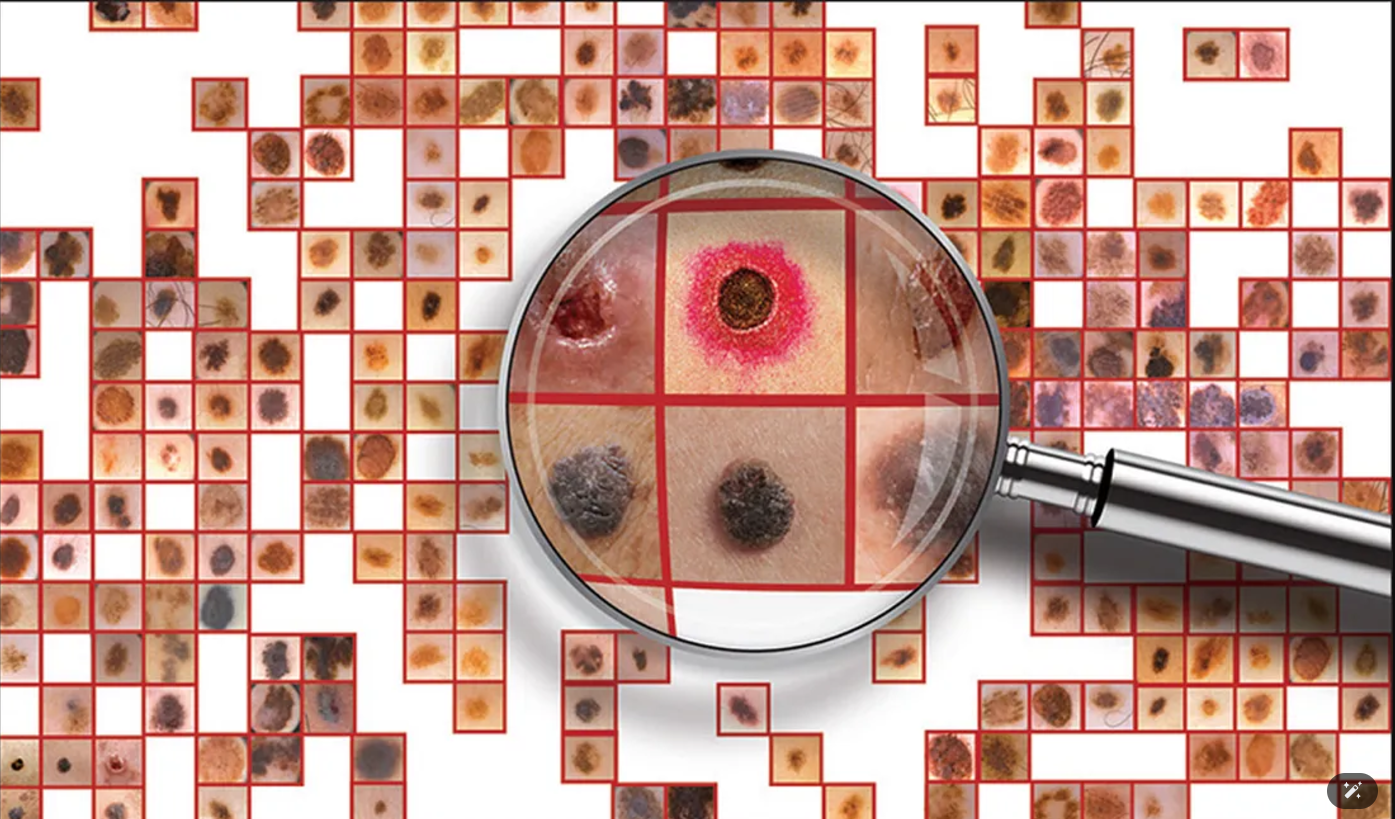

# **Introduction**

Skin cancer affects millions of lives, and its impact can be devastating if not detected early. Early diagnosis can mean the difference between life and loss—a truth I’ve experienced firsthand. A close friend of mine faced this battle, and it was only through timely detection and swift medical intervention that her life was saved. This experience inspired me to create something meaningful: a tool powered by technology that could help others catch skin cancer early, when treatment is most effective. This notebook represents a small, but heartfelt, contribution to the fight against cancer.

# **Why This Project Matters**

Cancer isn’t just a disease—it’s a story. It’s the waiting rooms, the anxious nights, and the endless "what-ifs." For my friend, her story took a hopeful turn because of an early and accurate diagnosis. But I know that many others aren't as fortunate.

With this project, I want to explore how artificial intelligence, specifically Convolutional Neural Networks (CNNs), can help bridge the gap. By automating the classification of skin cancer using dermoscopic images, we can give doctors and patients a powerful ally—one that acts quickly and accurately, potentially saving lives.

# **The Problem**

Detecting skin cancer early is crucial, but it’s not always straightforward. Medical professionals often rely on experience and expertise to identify abnormalities in dermoscopic images, and even then, there’s room for human error. In areas with limited access to specialists, the delays in diagnosis can lead to tragic outcomes.

The challenge is clear: we need a solution that’s fast, reliable, and accessible—something that can assist healthcare workers in making accurate decisions and empower patients with early knowledge about their condition.

# **The Goal**
This notebook is about creating a skin cancer classification model using CNNs and PyTorch. The goal is to:

* Build a system that can identify skin cancer with high accuracy using labeled medical images.
* Simplify the process of training and evaluating deep learning models for this task.
* Show how technology can be a force for good, especially in healthcare.

# **How It Works**
The notebook walks through the process step by step:

* **Loading the Data:** We’ll use a public dataset (e.g., HAM10000 or ISIC) containing real-world images of skin lesions.
* **Building the Model**: A Convolutional Neural Network (CNN) will act as the "brain" to detect patterns in these images and classify them.
* **Training and Evaluation**: We’ll train the model to distinguish between malignant and benign cases, evaluate its performance, and make improvements where necessary.
* **Deployment**: Finally, we’ll ensure that the trained model is ready for real-world use.


# **What This Means**

This project is more than a technical exercise—it’s a way to make a difference. Every line of code and every test is motivated by the hope that this tool might one day help someone. Whether it’s a doctor using this model for a second opinion or a patient getting an early diagnosis, the potential impact is profound. This notebook is dedicated to everyone whose lives have been touched by cancer—patients, families, and caregivers. It’s a reminder that even the smallest actions, like building a model, can carry the hope of saving lives.

In [2]:
#importing and loading the library with pytorch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from IPython import get_ipython
from IPython.display import display
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, datasets
from PIL import Image
from torchvision import models
from sklearn.metrics import roc_curve, auc, confusion_matrix


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the dataset path
datasets_path = '/content/drive/My Drive/Colab Notebooks/skin cancer 1'
if not os.path.exists(datasets_path):
    os.makedirs(datasets_path)

In [6]:
print(os.listdir(datasets_path))


['Data', 'train', 'test']


In [7]:
data_dir = '/content/drive/My Drive/Colab Notebooks/skin cancer 1'
# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [8]:
# Load datasets for train and test
datasets_dict = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'test']
}


In [9]:
# Create dataloaders for batching and shuffling
dataloaders = {
    x: DataLoader(datasets_dict[x], batch_size=32, shuffle=(x == 'train'), num_workers=4)
    for x in ['train', 'test']
}

# Print class names to confirm
class_names = datasets_dict['train'].classes
print("Classes:", class_names)

Classes: ['benign', 'malignant']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


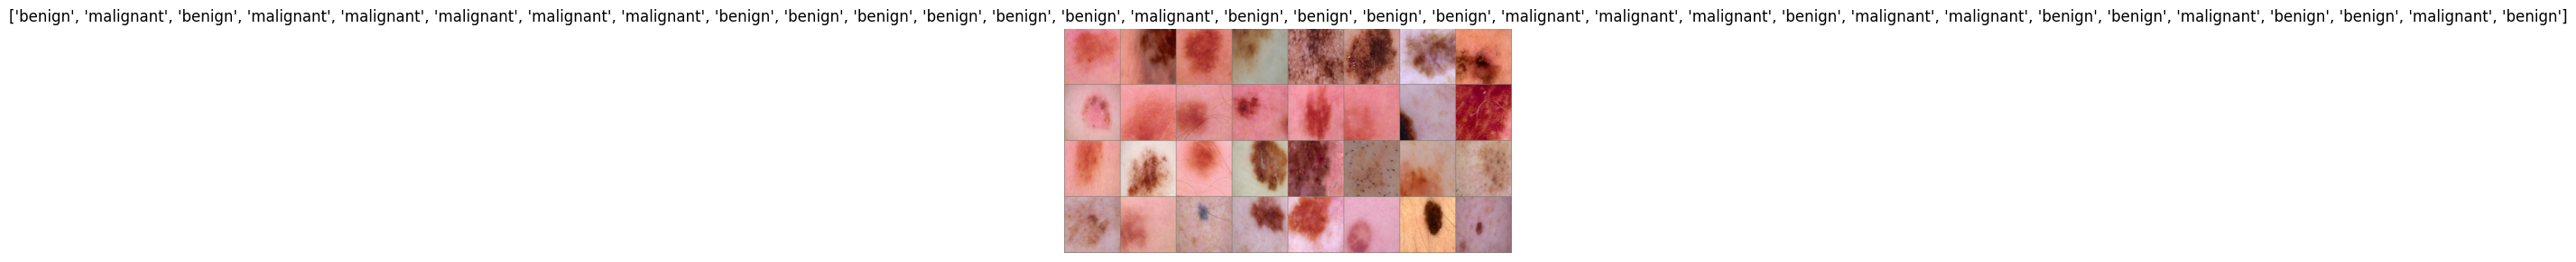

In [10]:
# Helper function to display images
def imshow(inp, title=None):
    """Display tensor as image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Visualize a batch of training images
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])


In [11]:
# Load ResNet18 model pretrained on ImageNet
model = models.resnet18(pretrained=True)

# Replace the final fully connected layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(class_names))  # len(class_names) = 2

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 79.8MB/s]


In [12]:
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adaptive learning rate


In [13]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, criterion, optimizer, num_epochs=25):
    history = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(datasets_dict[phase])
            epoch_acc = running_corrects.double() / len(datasets_dict[phase])

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['test_loss'].append(epoch_loss)
                history['test_acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return history


In [14]:
# Train the model
history = train_model(model, criterion, optimizer, num_epochs=10)


Epoch 1/10
----------
train Loss: 0.5006 Acc: 0.7763
test Loss: 0.3787 Acc: 0.8379
Epoch 2/10
----------
train Loss: 0.3851 Acc: 0.8146
test Loss: 0.3451 Acc: 0.8273
Epoch 3/10
----------
train Loss: 0.3569 Acc: 0.8305
test Loss: 0.4048 Acc: 0.8061
Epoch 4/10
----------
train Loss: 0.3345 Acc: 0.8385
test Loss: 0.4781 Acc: 0.7561
Epoch 5/10
----------
train Loss: 0.3493 Acc: 0.8373
test Loss: 0.3203 Acc: 0.8318
Epoch 6/10
----------
train Loss: 0.3337 Acc: 0.8460
test Loss: 0.3759 Acc: 0.8182
Epoch 7/10
----------
train Loss: 0.3313 Acc: 0.8441
test Loss: 0.3126 Acc: 0.8500
Epoch 8/10
----------
train Loss: 0.3228 Acc: 0.8445
test Loss: 0.3258 Acc: 0.8394
Epoch 9/10
----------
train Loss: 0.3207 Acc: 0.8525
test Loss: 0.3584 Acc: 0.8333
Epoch 10/10
----------
train Loss: 0.3190 Acc: 0.8532
test Loss: 0.3382 Acc: 0.8348


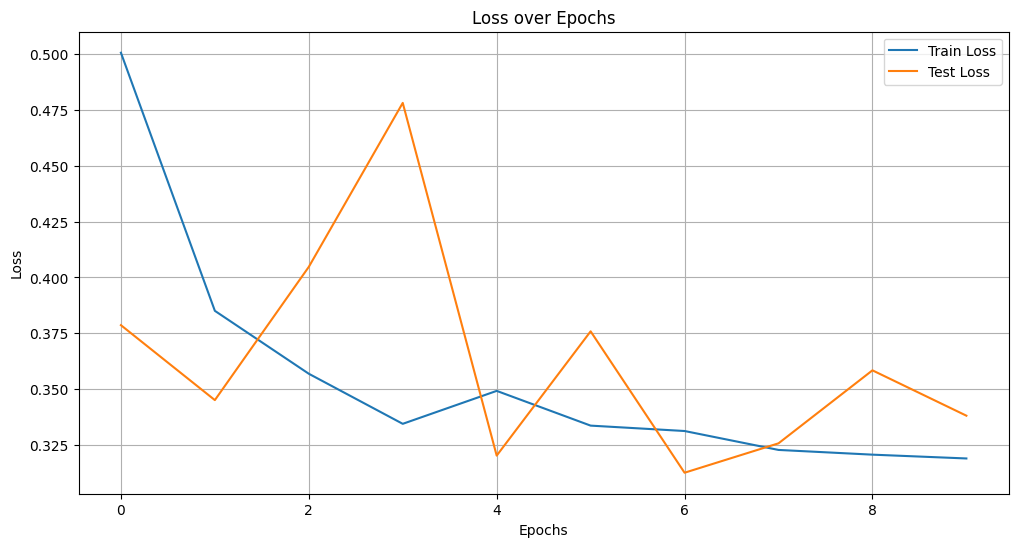

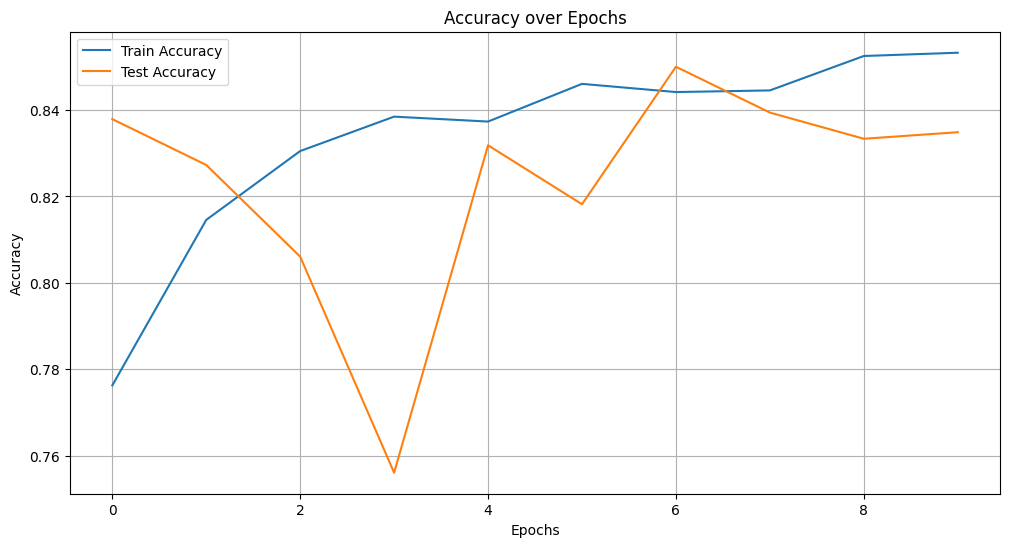

In [15]:
# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['test_acc'], label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


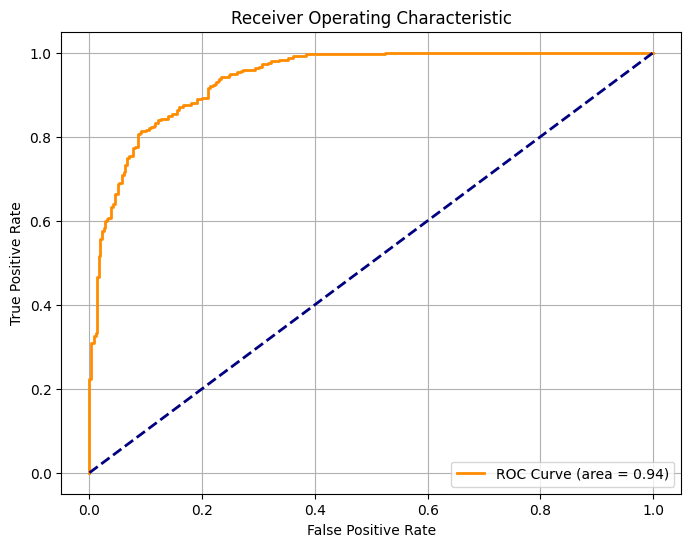

In [16]:
# Calculate probabilities for ROC curve
y_true, y_scores = [], []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        y_true.extend(labels.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid()
plt.show()


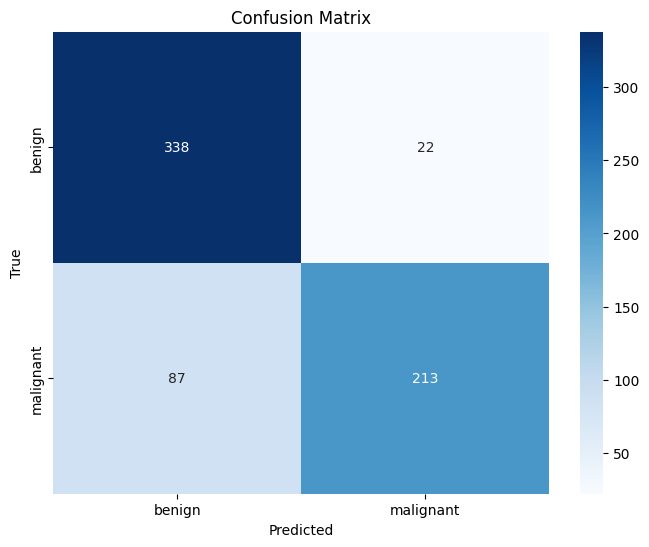

In [17]:
# Compute confusion matrix
cm = confusion_matrix(y_true, np.round(y_scores))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [18]:
from sklearn.metrics import classification_report, accuracy_score

# Convert scores to binary predictions (assuming a threshold of 0.5)
y_pred = np.round(y_scores)  # Convert probabilities to binary labels (0 or 1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Classification Report:
              precision    recall  f1-score   support

      Benign       0.80      0.94      0.86       360
   Malignant       0.91      0.71      0.80       300

    accuracy                           0.83       660
   macro avg       0.85      0.82      0.83       660
weighted avg       0.85      0.83      0.83       660

Accuracy: 0.83
